In [64]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
from matplotlib import pyplot as plt

%matplotlib notebook

In [66]:
print (p.shape)

(2, 7001)


<IPython.core.display.Javascript object>


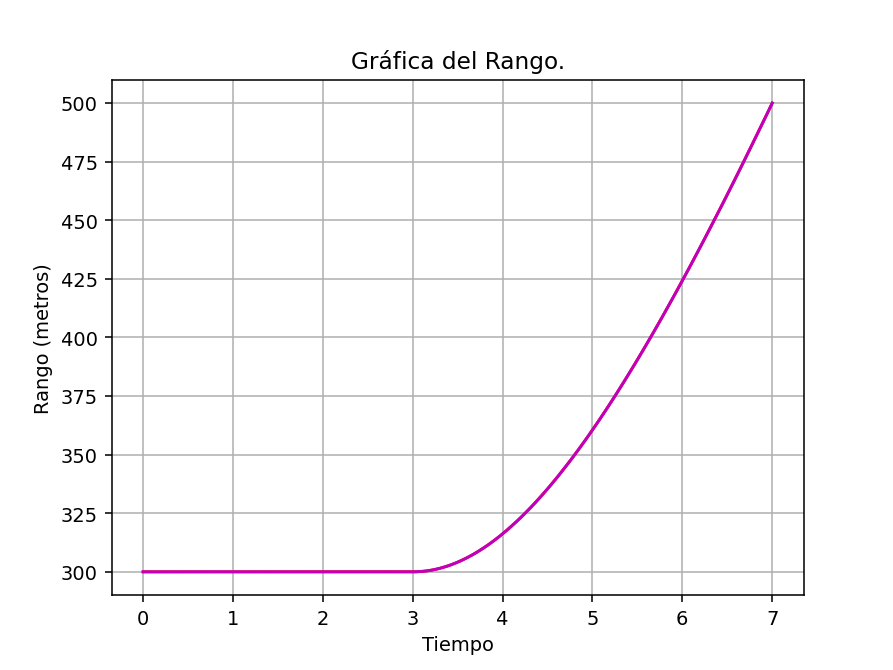

<IPython.core.display.Javascript object>


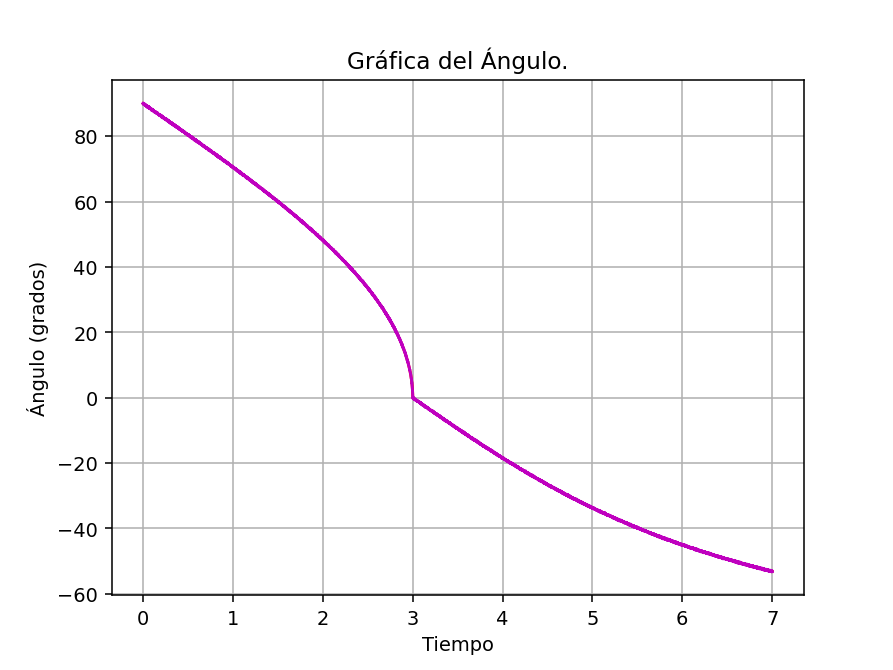

<IPython.core.display.Javascript object>


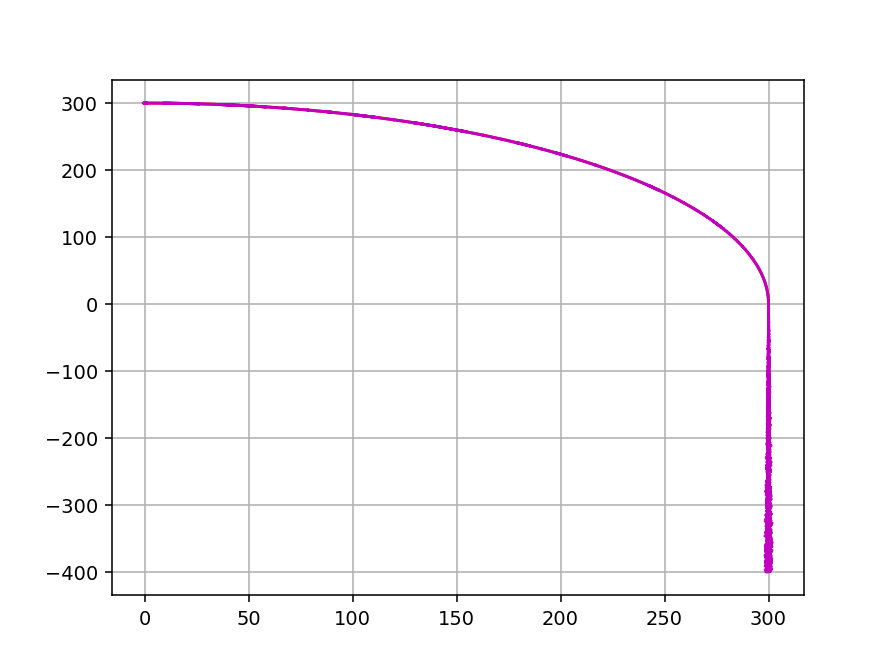

In [67]:
# Cargamos un archivo que contiene un trayectoria.
datTray = np.load ("curveMG2.npz")
print(datTray)

# Extraemos la información importante.
Crv = datTray['Crv'] # Curva y sus derivadas en coordenadas espaciales.
iCrv = datTray['iCrv'] # Curva proyectada en sus coordenadas espaciales en la imagen.
Z  = datTray['Z'] # Distancia entre la cámara y la superficie donde se mueve el obj.
 
Crv=p    
    
_, N = Crv.shape #Obtenemos el número de muestras con el que contamos.

# El intervalo de tiempo entre muestras.
dt = 0.001

#Le añadimos ruido a las mediciones de la trayectoria y generamos los datos de medición.
#definimos en ruido de medicion.
varA = 0.2**2
varRange = 0.005**2
varTheta = 0.0017**2

t = np.linspace(0, dt * N, N)

factNR = 1.

# Definimos el ruido de medición que vamos a añadir a los datos.
noiseRange   = rnd.normal(0, np.sqrt(varRange), (1, N))
noiseTheta  = rnd.normal(0, np.sqrt(varTheta), (1, N))

# Definimos el valor real de la trayectora del objeto, y su derivada.
rnge = np.sqrt(Crv[0,:]**2 + Crv[1,:]**2)
theta = np.arctan2(Crv[1,:],Crv[0,:])
z = np.vstack([rnge[:N], theta[:N]])

# Definimos la señal con la que vamos a trabajar: redondeando z y añadiendole error.
zn = z + factNR * np.vstack([noiseRange, noiseTheta])

# Graficamos el radio y el angulo
figA, axA = plt.subplots()
axA.plot(t, z[0,:], 'r', t, zn[0,:],'m')
axA.set(xlabel='Tiempo', ylabel='Rango (metros)',
       title='Gráfica del Rango.')
axA.grid()
figA.show()

figB, axB = plt.subplots()
axB.plot(t, z[1,:]*180/np.pi, 'r', t, zn[1,:]*180/np.pi,'m')
axB.set(xlabel='Tiempo', ylabel='Ángulo (grados)',
       title='Gráfica del Ángulo.')
axB.grid()
figB.show()

figC, axC = plt.subplots()
axC.plot(z[0,:]*np.cos(z[1,:]), z[0,:]*np.sin(z[1,:]), 'r', zn[0,:]*np.cos(zn[1,:]), zn[0,:]*np.sin(zn[1,:]), 'm')

axC.grid()
figC.show()

In [68]:
Crv.shape

(2, 7001)

In [69]:
# Definir nuestro sistema.

A = np.eye(6)
A[0, 1] = dt
A[0, 2] = 0.5*(dt**2)
A[1, 2] = dt
A[3, 4] = dt
A[3, 5] = 0.5*(dt**2)  
A[4, 5] = dt

P = 10 * np.eye(6)

Q = np.array([[(dt**4)/4, (dt**3)/2, (dt**2)/2, 0,         0,         0        ],\
              [(dt**3)/2,  dt**2,     dt,       0,         0,         0        ],\
              [(dt**2)/2,  dt,        1,        0,         0,         0        ],\
              [0,          0,         0,        (dt**4)/4, (dt**3)/2, (dt**2)/2],\
              [0,          0,         0,        (dt**3)/2, dt**2,     dt       ],\
              [0,          0,         0,        (dt**2)/2, dt,        1        ]])
Q = Q * varA
R = np.array([[varRange, 0], [0, varTheta]])

In [70]:
def ExtendedKalmanFilter (Xhat_k0, Phat_k0, U_k1, Z_k, A, B, DH, H, Q, R):
    #Predicción
    Xbar_k1 = np.dot(A, Xhat_k0) + np.dot(B, U_k1)
    Pbar_k1 = np.dot(A, np.dot(Phat_k0, A.transpose()))+Q
    
    #Actualización

    #Calculamos la ganancia.
    denom = np.dot(np.dot(DH, Pbar_k1), DH.transpose())+R
    if len(denom) > 1:
        denom = la.inv(denom)
    else:
        denom = 1. / denom
    Kgain = np.dot(np.dot(Pbar_k1, DH.transpose()),denom)

    # Actualizamos el Estado y su incertidumbre.
    Xhat_k1 = Xbar_k1 + np.dot(Kgain, (Z_k- H))

    PhatLeft = np.eye(len(Xhat_k0))-np.dot(Kgain,DH)
    Phat_k1 = np.dot(np.dot(PhatLeft, Pbar_k1), PhatLeft.transpose())
    Phat_k1 = Phat_k1 + np.dot(np.dot(Kgain, R), Kgain.transpose())
    
    return Xhat_k1, Phat_k1, Xbar_k1

In [71]:
#Definimos valores iniciales
x = np.array([-1.3, 0, 0, -4.8, 0, 0])
P = 500 * np.eye(6)

#Definimos matrices para almacenar la evolucion del sistema.
Xbar=np.zeros((N, 6))
Xhat=np.zeros((N, 6))
Phat=np.zeros((N, 6, 6))

#Inicializamos valor 0 de la estimacion del estado y su incertidumbre (Mat. Cov)
Xhat[0,:], Phat[0,:,:] = x, P

for idx in range(1,N):
    Z = zn[:, idx] #Obtenemos una medicion.
    x = Xhat[idx-1][0]
    y = Xhat[idx-1][3]
    H = np.array([[x/(np.sqrt(x**2 + y**2)), 0, 0, y/(np.sqrt(x**2 + y**2)), 0, 0],\
                   [-y/(x**2 + y**2), 0, 0, x/(x**2 + y**2), 0, 0]])
    h = np.array([np.sqrt(x**2 + y**2), np.arctan2(y, x)])
    
    Xhat[idx,:], Phat[idx,:,:], Xbar[idx,:] = ExtendedKalmanFilter (Xhat[idx-1], Phat[idx-1], 0, Z, A, 0, H, h, Q, R)

<IPython.core.display.Javascript object>


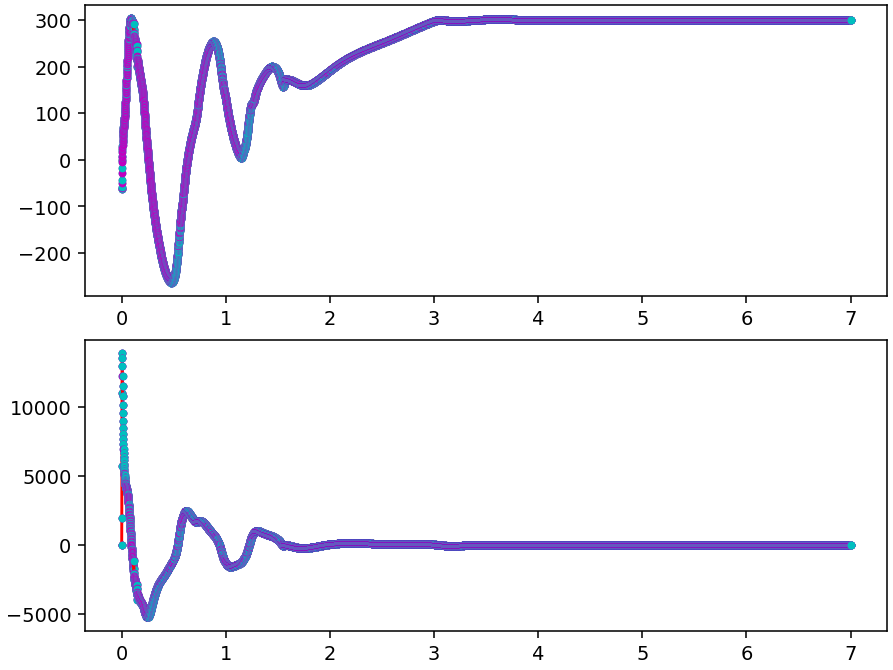

ValueError: x and y must have same first dimension, but have shapes (7001,) and (1250,)

In [72]:
#Graficamos la Posicion.
fig2, (ax21, ax22) = plt.subplots(2, 1, layout='constrained')
i=1

ax21.plot((t[i-1],t[i]),(Xhat[i-1,0],Xhat[i,0]),'r', label='posición estimada')
ax21.plot((t[i-1],t[i]),(Xhat[i-1,0],Xbar[i,0]),'m.', label='posición predicha')
ax21.plot((t[i],t[i]),(Xbar[i,0],Xhat[i,0]),'c.', label='posición corregida')
ax22.plot((t[i-1],t[i]),(Xhat[i-1,1],Xhat[i,1]),'r', label='posición estimada')
ax22.plot((t[i-1],t[i]),(Xhat[i-1,1],Xbar[i,1]),'m.', label='posición predicha')
ax22.plot((t[i],t[i]),(Xbar[i,1],Xhat[i,1]),'c.', label='posición corregida')
for i in range(2,N):
    ax21.plot((t[i-1],t[i]),(Xhat[i-1,0],Xhat[i,0]),'r')
    ax21.plot((t[i-1],t[i]),(Xhat[i-1,0],Xbar[i,0]),'m.')
    ax21.plot((t[i],t[i]),(Xbar[i,0],Xhat[i,0]),'c.')
    ax22.plot((t[i-1],t[i]),(Xhat[i-1,1],Xhat[i,1]),'r')
    ax22.plot((t[i-1],t[i]),(Xhat[i-1,1],Xbar[i,1]),'m.')
    ax22.plot((t[i],t[i]),(Xbar[i,1],Xhat[i,1]),'c.')
ax21.plot(t,iCrv[0,:],'k', linewidth=0.5, label='posición ideal')
ax22.plot(t,iCrv[1,:],'k', linewidth=0.5, label='posición ideal')

ax21.set(xlabel='tiempo', ylabel='Posición horizontal]',
       title='Gráfica de la posición horizontal')
ax21.grid()
ax22.set(xlabel='tiempo', ylabel='Posición vertical',
       title='Gráfica de la posición vertical')
ax22.grid()

legend21 = ax21.legend(loc='lower right', shadow=True, fontsize='x-small')
legend21 = ax22.legend(loc='lower center', shadow=True, fontsize='x-small')


<IPython.core.display.Javascript object>


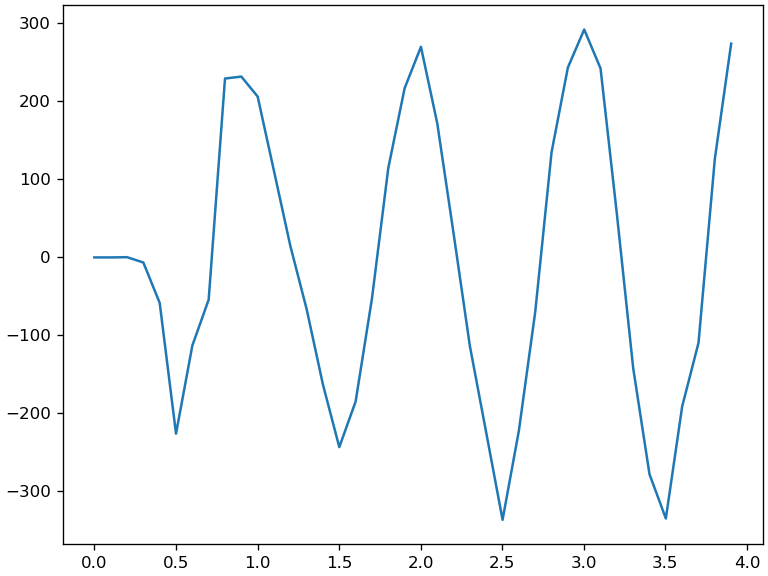

In [46]:
fig3, ax3 = plt.subplots(1, 1, layout='constrained')
T=40
ax3.plot(t[:T],Xbar[:T,1])